# More trajectory analysis with MDAnalysis

This notebook contains additional examples for how to use MDAnalysis. These examples could not be included into the workshop due to time constraints.

In [2]:
import matplotlib.pyplot as plt
import seaborn.apionly as sns
%matplotlib inline

plt.style.use('ggplot')
sns.set_style('ticks')

import MDAnalysis.tests.datafiles as data
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis.rms import rmsd

All the examples use example trajectories available from the Dropbox folder [CECAM_Workshop/MDAnalysis](https://www.dropbox.com/sh/ln0klc9j7mhvxkg/AAB0gMcPPsrDhdVrM2PWmopXa?dl=0) (or follow the [command line download instructions](http://becksteinlab.github.io/MDAnalysis-workshop/datadownload.html#data-download)). In the following it is assumed that these trajectories reside in a directory `./CECAM_Workshop/MDAnalysis`.

In [3]:
top = "./CECAM_Workshop/MDAnalysis/Optional/md.gro"
trj = "./CECAM_Workshop/MDAnalysis/Optional/md_fit_first-10ns-s10.xtc"

u = mda.Universe(top, trj)

## MSD
Calculate the mean square displacement over all water molecules. This is not a very meaningful calculation because the periodic boundary conditions are not taken into account; in order to calculate e.g., the diffusion coefficient, one has to unwrap the water trajectories. 

In [4]:
u = mda.Universe(top, trj)
ow = u.select_atoms("name OW")
x0 = ow.positions.copy()
data = np.zeros((len(u.trajectory), 2))
for ts in u.trajectory:
    data[ts.frame,:] = ts.time, np.mean(np.sum(np.square(ow.positions - x0), axis=1))

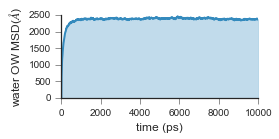

In [10]:
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
color = sns.color_palette()[1]
ax.fill_between(data[:,0], data[:,1], alpha=0.3, color=color)
ax.plot(data[:,0], data[:,1], color=color, linewidth=2)
sns.despine(ax=ax)
ax.set_xlabel("time (ps)")
ax.set_ylabel(r"water OW MSD($\AA$)")
plt.tight_layout()
fig.savefig("ow_msd.pdf")

## Ca RMSF
From analysis.rms.RMSF

In [7]:
import numpy as np
import MDAnalysis as mda

#u = mda.Universe("topol.tpr", "trj.xtc")
ca = u.select_atoms("name CA")
means = np.zeros((len(ca), 3))
sumsq = np.zeros_like(means)
for k, ts in enumerate(u.trajectory):
    sumsq += (k/(k+1.0)) * (ca.positions - means)**2
    means[:] = (k*means + ca.positions)/(k+1.0)
rmsf = np.sqrt(sumsq.sum(axis=1)/(k+1.0))

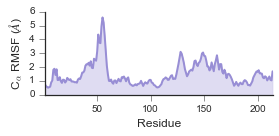

In [9]:
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
color = sns.color_palette()[2]
ax.fill_between(ca.residues.resids, rmsf, alpha=0.3, color=color)
ax.plot(ca.residues.resids, rmsf, lw=2, color=color)
sns.despine(ax=ax)
ax.set_xlabel("Residue")
ax.set_ylabel(r"C$_\alpha$ RMSF ($\AA$)")
ax.set_xlim(1, max(ca.residues.resids))
plt.tight_layout()
fig.savefig("ca_rmsf.pdf")

## LeafletFinder 

Track the self assembly of a lipid membrane around a protein. The trajectories are also available in the dropbox folder [./CECAM_Workshop/MDAnalysis/Optional/TRPV1_small/MD](https://www.dropbox.com/sh/ln0klc9j7mhvxkg/AACUQTVBcMO3_NzsZFpBy2zZa/Optional/TRPV1_small/MD?dl=0).

Below we implement the key steps in the *LeafletFinder* algorithm (see [1])

[1] N. Michaud-Agrawal, E. J. Denning, T. B. Woolf, and O. Beckstein. MDAnalysis: A toolkit for the analysis of molecular dynamics simulations. J Comp Chem, 32:2319–2327, 2011. doi: [10.1002/jcc.21787](http://doi.org/10.1002/jcc.21787).

In [11]:
pdb = "./CECAM_Workshop/MDAnalysis/Optional/TRPV1_small/MD/md.pdb"
xtc = "./CECAM_Workshop/MDAnalysis/Optional/TRPV1_small/MD/md_centered.xtc"

u = mda.Universe(pdb, xtc)

u.trajectory[-1]

headgroup_atoms = u.select_atoms("name P*")
x = headgroup_atoms.positions

In [12]:
from MDAnalysis.lib.distances import distance_array
adj = (distance_array(x, x) < 12)

In [23]:
import networkx as nx 
leaflets = sorted([list(component) for component in nx.connected_components(nx.Graph(adj))], key=len, reverse=True)

A_lipids = headgroup_atoms[leaflets[0]].residues 
B_lipids = headgroup_atoms[leaflets[1]].residues

In [24]:
len(leaflets)

3

See the [MDAnalysis.analysis.leaflets](http://pythonhosted.org/MDAnalysis/documentation_pages/analysis/leaflet.html) module for a full-fledged implementation.